# Training GCN AE on Full Data

In [1]:
import torch
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optuna

from models import GraphAE
from parameters import GraphAEParameters, TrainingParameters
from datautils import get_morning_data, get_gcnae_sequence, normalize_data, generate_edges, generate_relational_edges, load_best_parameters, get_full_data, label_anomalies
from training import save_model, load_model, train_gcnae, compute_anomaly_threshold_gcnae, test_model, threshold_anomalies, fill_result_df, test_gcnae
from metrics import calculate_accuracy, crash_detection_delay, calculate_tp_fp, find_thresholds, find_delays, find_percent, discrete_fp_delays, generate_anomaly_labels, calculate_auc, discrete_fp_delays_loc
import torch.nn as nn
from tqdm import tqdm

import random
import os
import torch_geometric
seed = 42
torch_geometric.seed_everything(seed)

/media/vanderbilt/home/zulqarnain/anaconda3/envs/traffic-anomaly/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Time Series Sequencing

In [2]:
def sequence_gcnae(data, timesteps, hide_anomalies=False):
    sequence = []
    static_edges = generate_edges(milemarkers=list(range(49)))
    unique_times = np.unique(data['unix_time'])
    kept_indices = []

    for index, t in enumerate(tqdm(unique_times)):
        data_t = []
        contains_anomaly = np.any([np.unique(data[data['unix_time']==t]['anomaly'])[0]])

        if (hide_anomalies and contains_anomaly):
            continue
        
        kept_indices.append(index)

        data_t.append(data[data['unix_time']==t][['occ', 'speed', 'volume']].to_numpy()) # assumes time indices come sequentially, with full data it may not
        
        curr_data = data_t[-1]
        curr_graph = Data(x=torch.tensor(curr_data, dtype=torch.float32), edge_index=static_edges)
        sequence.append(curr_graph)

    return sequence, kept_indices

### Loading Hyperparameters

In [3]:
hide_anomalies = True
optimal_hyperparams = load_best_parameters('gcn',hide_anomalies=hide_anomalies)

In [4]:
optimal_hyperparams

{'dropout': 0.084357192353011,
 'epochs': 9,
 'gcn_hidden_dim': 16,
 'latent_dim': 64,
 'learning_rate': 0.004496304393912344,
 'num_gcn': 1,
 'timesteps': 4}

In [5]:
mse_weights = [1,1,1] # weights for loss function (occupancy, speed, volume)

In [6]:
training_params = TrainingParameters(
    learning_rate=optimal_hyperparams['learning_rate'],
    batch_size=1,
    timesteps=optimal_hyperparams['timesteps'],
    n_epochs=optimal_hyperparams['epochs'],
)

In [7]:
data, test_data, _ = get_full_data()
data = normalize_data(data)
data = label_anomalies(data)
length = len(data.day.unique())
train_length = int(length * 0.8)
val_length = length - train_length
train_days = data.day.unique()[:train_length]
val_days = data.day.unique()[train_length:]

# Use .isin() to filter the DataFrame based on the days
train_data = data[data.day.isin(train_days)]
val_data = data[data.day.isin(val_days)]
train_sequence, kept_train_indices = sequence_gcnae(train_data, training_params.timesteps, hide_anomalies=hide_anomalies)
val_sequence, kept_val_indices = sequence_gcnae(val_data, training_params.timesteps, hide_anomalies=hide_anomalies)


100%|██████████| 2880/2880 [00:00<00:00, 2968.00it/s]


In [8]:
hyperparams = GraphAEParameters(
    num_features=3,
    latent_dim=optimal_hyperparams['latent_dim'],
    gcn_hidden_dim=optimal_hyperparams['gcn_hidden_dim'],
    dropout=optimal_hyperparams['dropout'],
    num_gcn=optimal_hyperparams['num_gcn']
)

In [9]:
# ae = GraphAE(hyperparams)

### Model Training or Loading

In [10]:
using_pretrained = True

In [11]:
if not using_pretrained:
    ae, losses = train_gcnae(gcnaeparams=hyperparams, trainingparams=training_params, training_data=train_sequence, mse_weights=mse_weights, verbose=True)
    save_model(ae, f'gcn_{hide_anomalies}_{seed}')
else:
    ae = load_model(GraphAE, hyperparams, f'gcn_{hide_anomalies}_{seed}')

In [12]:
if not using_pretrained:
    plt.plot(losses)

### Computing Node-level Anomaly Threshold

In [13]:
thresh = compute_anomaly_threshold_gcnae(val_sequence, ae, mse_weights, 'max')

100%|██████████| 1273/1273 [00:01<00:00, 831.83it/s]


### Loading Test Data

In [14]:
_, df_test_data, _ = get_full_data()

In [15]:
test_data = normalize_data(df_test_data)
test_data = label_anomalies(test_data)
test_data, kept_test_indices = sequence_gcnae(test_data, training_params.timesteps, hide_anomalies=False)

100%|██████████| 4800/4800 [00:03<00:00, 1544.93it/s]


In [16]:
test_errors, test_recons_speeds, test_true_speeds = test_gcnae(test_data, mse_weights, ae)

In [17]:
# Compute true anomaly labels
anomaly_labels = generate_anomaly_labels(df_test_data, kept_test_indices)

# Whether a crash was reported at each time
# crash_reported = df_test_data['crash_record'].to_numpy()[0::196][kept_test_indices]

In [18]:
converted_dates_utc = pd.to_datetime(df_test_data.unix_time, unit='s', utc=True)

# Step 2: Convert to US/Central timezone
converted_dates_central = converted_dates_utc.dt.tz_convert('US/Central')
converted_dates_naive = converted_dates_central.dt.tz_localize(None)
df_test_data['Time']=converted_dates_naive

import glob
pattern=sorted(glob.glob('../data/event_data/2023-10-*.csv'))
events=pd.DataFrame()
for i in pattern:
    event=pd.read_csv(i,sep=';')
    events=pd.concat([events,event],axis=0)
events.reset_index(drop=True,inplace=True)
# events['timestamp']=pd.to_datetime(events['event_update_time'],utc=False)
events['Time'] = pd.to_datetime(events['event_update_time'], utc=False)

# To ensure the timestamps are naive (no timezone)
events['Time'] = events['Time'].dt.tz_localize(None).dt.floor('1s').dt.ceil('30s')
events=events[(events['event_update_type'] == 'new') & (events['classification']=='incident')]
events.drop_duplicates(subset=['event_id'],inplace=True)
events=events.sort_values(by='Time').reset_index(drop=True)


array1=np.array(events.milemarker.sort_values().unique())
array2=np.array(df_test_data.milemarker.unique())
def find_closest_or_exact(target, array):
    # Find the indices where the target would fit
    idx = np.searchsorted(array, target)
    
    # Check for exact match
    if idx < len(array) and array[idx] == target:
        return array[idx]  # Exact match
    
    # Find the closest lower value (if it exists)
    lower = array[idx - 1] if idx > 0 else None
    
    # Find the closest higher value (if it exists)
    higher = array[idx] if idx < len(array) else None
    
    return [lower, higher]

# Mapping from array2 to closest values in array1
events['mapped_milemarkers'] = events['milemarker'].apply(lambda x: find_closest_or_exact(x, array2))
events=events.explode('mapped_milemarkers')
# Filter events based on Time in df_test_data
test_events = events[events['Time'].isin(df_test_data['Time'])]

# Ensure 'Time' in test_events is properly converted to pandas.Timestamp
test_events['Time'] = pd.to_datetime(test_events['Time'])

df_test_data['combined'] = df_test_data['Time'].astype(str) + '_' + df_test_data['milemarker'].astype(str)
test_events['combined'] = test_events['Time'].astype(str) + '_' + test_events['mapped_milemarkers'].astype(str)

df_test_data['exists'] = df_test_data['combined'].isin(test_events['combined']).astype(int)
df_test_data['crash_record']=((df_test_data['exists'] == 1) & (df_test_data['crash_record'] == 1)
).astype(int)
crash_reported=df_test_data['crash_record'].to_numpy().reshape(-1,196)[kept_test_indices]



/tmp/ipykernel_2222602/3884504702.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_data['Time']=converted_dates_naive
/tmp/ipykernel_2222602/3884504702.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_events['Time'] = pd.to_datetime(test_events['Time'])
/tmp/ipykernel_2222602/3884504702.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [19]:
path_results = 'saved_results/gcn/'
results = discrete_fp_delays_loc(thresh, test_errors, anomaly_labels, crash_reported)

# Check if the directory exists, and create it if it does not
if not os.path.exists(path_results):
    os.makedirs(path_results)

# Save the results to a CSV file
# results.to_csv(f'{path_results}results_{hide_anomalies}_{seed}.csv', index=False)

100%|██████████| 1000/1000 [00:28<00:00, 35.33it/s]

Found FPR of 0.009799918334013884 for 0.01
Found FPR of 0.02490812576561862 for 0.025
Found FPR of 0.04981625153123724 for 0.05
Found FPR of 0.1000408329930584 for 0.1
Found FPR of 0.20171498570845242 for 0.2
FPR 1% gives mean delay of -3.857142857142857 +/- 8.236305888799757 with mean. distance of 5.0458333333333325 +/- 4.249434194363083 while missing 0.30000000000000004%.
FPR 2.5% gives mean delay of -8.0 +/- 6.649382355849731 with mean. distance of 5.104166666666667 +/- 4.282934076723053 while missing 0.30000000000000004%.
FPR 5% gives mean delay of -14.428571428571429 +/- 1.207966751806269 with mean. distance of 2.8636363636363633 +/- 3.4351849830494707 while missing 0.30000000000000004%.
FPR 10% gives mean delay of -13.8125 +/- 2.14967294023998 with mean. distance of 2.192105263157895 +/- 3.152745802341639 while missing 0.19999999999999996%.
FPR 20% gives mean delay of -13.85 +/- 1.8309833423600554 with mean. distance of 2.761111111111111 +/- 3.9036386950803217 while missing 0.0%.

In [20]:
_, df_test_data, _ = get_full_data()
test_data = normalize_data(df_test_data)
test_data = label_anomalies(test_data)
test_data, kept_test_indices = sequence_gcnae(test_data, training_params.timesteps, hide_anomalies=False)
crash_reported = df_test_data['crash_record'].to_numpy()[0::196][kept_test_indices]
results=discrete_fp_delays(thresh, test_errors, anomaly_labels, crash_reported)

100%|██████████| 1000/1000 [00:28<00:00, 35.37it/s]

Found FPR of 0.009799918334013884 for 0.01
Found FPR of 0.02490812576561862 for 0.025
Found FPR of 0.04981625153123724 for 0.05
Found FPR of 0.1000408329930584 for 0.1
Found FPR of 0.20171498570845242 for 0.2
FPR 1% gives mean delay of -4.666666666666667 +/- 7.434902674398487 while missing 0.25%.
FPR 2.5% gives mean delay of -8.055555555555555 +/- 5.866308911650799 while missing 0.25%.
FPR 5% gives mean delay of -13.055555555555555 +/- 2.7833277888611887 while missing 0.25%.
FPR 10% gives mean delay of -12.7 +/- 2.9427877939124323 while missing 0.16666666666666663%.
FPR 20% gives mean delay of -13.166666666666666 +/- 2.3746344747958346 while missing 0.0%.


In [22]:
results = discrete_fp_delays(thresh, test_errors, anomaly_labels, crash_reported)

100%|██████████| 1000/1000 [00:30<00:00, 32.68it/s]

Found FPR of 0.009799918334013884 for 0.01
Found FPR of 0.02490812576561862 for 0.025
Found FPR of 0.04981625153123724 for 0.05
Found FPR of 0.09963250306247448 for 0.1
Found FPR of 0.20171498570845242 for 0.2
FPR 1% gives mean delay of -9.1 +/- 7.578918128598566 while missing 0.33333333333333337%.
FPR 2.5% gives mean delay of -9.1 +/- 7.578918128598566 while missing 0.33333333333333337%.
FPR 5% gives mean delay of -9.375 +/- 6.055730756894662 while missing 0.19999999999999996%.
FPR 10% gives mean delay of -8.833333333333334 +/- 8.79709548026443 while missing 0.0%.
FPR 20% gives mean delay of -14.2 +/- 1.3638181696985856 while missing 0.0%.


In [20]:
calculate_auc(test_errors,anomaly_labels)

0.7040200333721499

### Compute FPR / Crash Detection Delay Tradeoff

In [24]:
delay_results = np.array(find_delays(thresh, test_errors, anomaly_labels, crash_reported))

100%|██████████| 1000/1000 [00:28<00:00, 34.53it/s]
/media/vanderbilt/home/zulqarnain/anaconda3/envs/traffic-anomaly/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/media/vanderbilt/home/zulqarnain/anaconda3/envs/traffic-anomaly/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/media/vanderbilt/home/zulqarnain/anaconda3/envs/traffic-anomaly/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/media/vanderbilt/home/zulqarnain/anaconda3/envs/traffic-anomaly/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/media/vanderbilt/home/zulqarnain/anaconda3/envs/traffic

In [25]:
delay_df = pd.DataFrame(delay_results, columns=['FPR', 'Mean Delay', 'Std Delay', 'Found Percent'])
delay_df.to_csv('./saved_results/gcnae_fp_delay.csv')

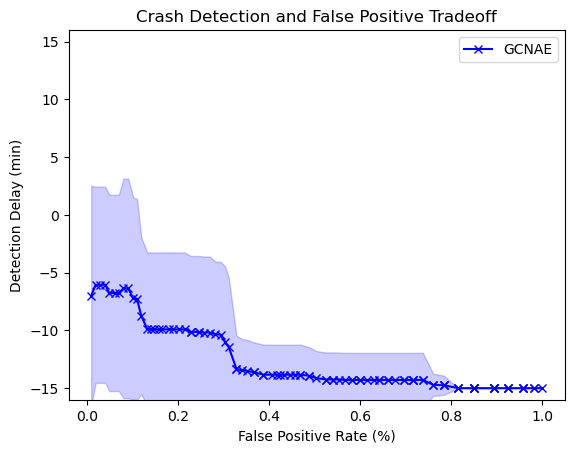

In [26]:
x_values = delay_df['FPR']
y_values = delay_df['Mean Delay'] / 2
std_values = delay_df['Std Delay'] / 2

plt.plot(x_values, y_values, color='blue', label='GCNAE', marker='x')

lower_bound = y_values - std_values  # 1.96 is the z-score for 95% confidence interval
upper_bound = y_values + std_values

plt.fill_between(x_values, lower_bound, upper_bound, color='blue', alpha=0.2)
plt.ylim(-16, 16)
# plt.xlim(-0.01,1)
plt.xlabel("False Positive Rate (%)")
plt.ylabel("Detection Delay (min)")
plt.title("Crash Detection and False Positive Tradeoff")
plt.legend()
plt.show()

In [ ]:
path_results = 'saved_results/gcn/'
results = discrete_fp_delays(thresh, test_errors, anomaly_labels, crash_reported)

# Check if the directory exists, and create it if it does not
if not os.path.exists(path_results):
    os.makedirs(path_results)

# Save the results to a CSV file
results.to_csv(f'{path_results}results_{hide_anomalies}_{seed}.csv', index=False)

100%|██████████| 1000/1000 [00:28<00:00, 35.16it/s]

Found FPR of 0.009799918334013884 for 0.01
Found FPR of 0.02531645569620253 for 0.025
Found FPR of 0.049407921600653326 for 0.05
Found FPR of 0.09799918334013884 for 0.1
Found FPR of 0.20253164556962025 for 0.2
FPR 1% gives mean delay of -7.0 +/- 9.513148795220223 while missing 0.33333333333333337%.
FPR 2.5% gives mean delay of -6.05 +/- 8.492496688253697 while missing 0.16666666666666663%.
FPR 5% gives mean delay of -6.75 +/- 8.500735262317018 while missing 0.16666666666666663%.
FPR 10% gives mean delay of -6.7727272727272725 +/- 9.163573232105765 while missing 0.08333333333333337%.
FPR 20% gives mean delay of -9.909090909090908 +/- 6.6599828754154045 while missing 0.08333333333333337%.


### Compute AUC

In [20]:
calculate_auc(test_errors, anomaly_labels)

0.7106100247518514

### Copmute Detection Delay Histogram on Full Dataset

In [29]:
_, _, full_data = get_full_data()
full_data = normalize_data(full_data)
full_data = label_anomalies(full_data)

In [30]:
full_sequence, kept_full_indices = sequence_gcnae(full_data, training_params.timesteps, hide_anomalies=False)

  0%|          | 0/18240 [00:00<?, ?it/s]

100%|██████████| 18240/18240 [00:24<00:00, 738.43it/s]


In [31]:
full_errors, _, _ = test_gcnae(full_sequence, mse_weights, ae)

In [32]:
full_anomalies = generate_anomaly_labels(full_data, kept_full_indices)
crash_reported = full_data['crash_record'].to_numpy()[0::196][kept_full_indices]

In [33]:
full_thresholds = find_thresholds(thresh, full_errors, full_anomalies)

100%|██████████| 1000/1000 [01:51<00:00,  8.94it/s]


In [34]:
offset = find_percent(full_thresholds, 10)
full_anomaly_pred = threshold_anomalies(thresh+offset, full_errors)


Found FPR of 0.1004164738546969 for 0.1


In [35]:
delay, found = crash_detection_delay(full_anomaly_pred, crash_reported)

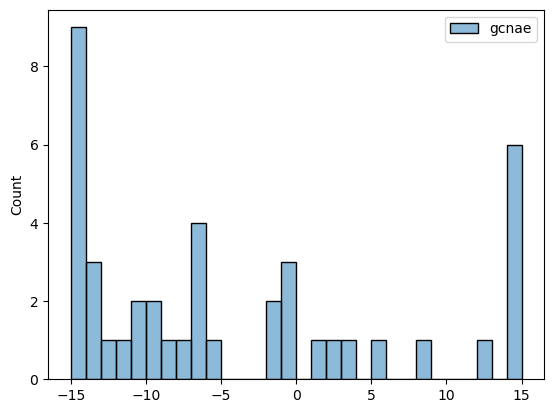

In [36]:
import seaborn as sns 

delay = delay + [30] * (len(found) - np.count_nonzero(found))

sns.histplot(np.array(delay)/2, binwidth=1, alpha=0.5, label='gcnae')
plt.legend()

In [37]:
np.save('./saved_results/gcnae10delays.npy', np.array(delay)/2)

In [38]:
_, df_clean_test_data, _ = get_full_data()

In [39]:
clean_test_data = normalize_data(df_clean_test_data)
clean_test_data = label_anomalies(clean_test_data)
clean_test_data, kept_test_indices = sequence_gcnae(clean_test_data, training_params.timesteps, hide_anomalies=True)

 13%|█▎        | 621/4800 [00:00<00:01, 2217.58it/s]

100%|██████████| 4800/4800 [00:02<00:00, 2214.05it/s]


In [40]:
clean_test_errors, test_recons_speeds, test_true_speeds = test_gcnae(clean_test_data, mse_weights, ae)

In [41]:
np.mean(clean_test_errors)

0.009193928

In [42]:
# data = fill_result_df(anomalies_10, test_true_speeds, test_recons_speeds, training_params.timesteps)

In [43]:
# data.to_csv('./saved_results/full_results_test_rstae.csv')

In [44]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# data = pd.read_csv('./saved_results/full_results_test_rstae.csv', index_col=0)
# data['Time Index'] = pd.to_datetime(data['Time Index'] * 30, unit='s')
# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# lane = data[data.Lane == 1]
# # plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
# #                             c=lane['Reconstructed Speed'].values,marker='s',s=1, cmap='RdYlGn')
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=np.abs(lane['Reconstructed Speed'].values-lane['Speed']),marker='s',s=1, cmap='viridis')
# plt.gca().invert_yaxis()
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# plt.title("Reconstructed Speeds Lane 1 Thursday, Oct 26, Morning")
# plt.xlabel("Time of Day")
# plt.ylabel("Milemarker")
# plt.show()

In [45]:
# from matplotlib.ticker import MultipleLocator

# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# lane = data[data.Lane == 1]
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=lane['Speed'].values,marker='s',s=1, cmap='RdYlGn')
# plt.gca().invert_yaxis()
# # plt.gca().xaxis.set_major_locator(MultipleLocator(0.01))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# # Set x-axis limits
# start_time = pd.to_datetime('1970-01-01 09:30:00')
# end_time = pd.to_datetime('1970-01-01 09:50:00')
# # plt.xlim(start_time, end_time)
# # plt.ylim()

# plt.title("True Speeds Lane 1 Thursday, Oct 26, Morning")
# plt.xlabel("Time of Day")
# plt.ylabel("Milemarker")
# plt.show()

In [46]:
# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# lane = data[data.Lane == 1]
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=lane['Anomaly'].values,marker='s',s=1, cmap='viridis', label='Nominal')
# plt.gca().invert_yaxis()
# # plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# # Set x-axis limits
# start_time = pd.to_datetime('1970-01-01 08:00:00')
# end_time = pd.to_datetime('1970-01-01 11:00:00')
# # plt.xlim(start_time, end_time)

# # Add vertical line at '1970-01-01 09:39:22'
# vline_time = pd.to_datetime('1970-01-01 09:39:22')
# plt.axvline(x=vline_time, color='red', linestyle='--', linewidth=2, label='Crash Reported', alpha=0.25)
# plt.axhline(y=62.2, color='red', linestyle='--', alpha=0.25)
# # plt.ylim(60,65)
# plt.legend(loc='upper right')
# plt.title("Anomaly Detection Lane 1 Thursday Oct 26, Morning")
# plt.xlabel("Time of Day")
# plt.ylabel("Milemarker")
# plt.show()